# Cats & Dogs: Tackle Overfitting with Data Augmentation

In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Directory that holds the data
DATA_DIR = './PetImages'

# Subdirectories for each class
data_dir_dogs = os.path.join(DATA_DIR, 'Dog')
data_dir_cats = os.path.join(DATA_DIR, 'Cat')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_dogs))} images of dogs.")
print(f"There are {len(os.listdir(data_dir_cats))} images of cats.")

There are 11211 images of dogs.
There are 11223 images of cats.


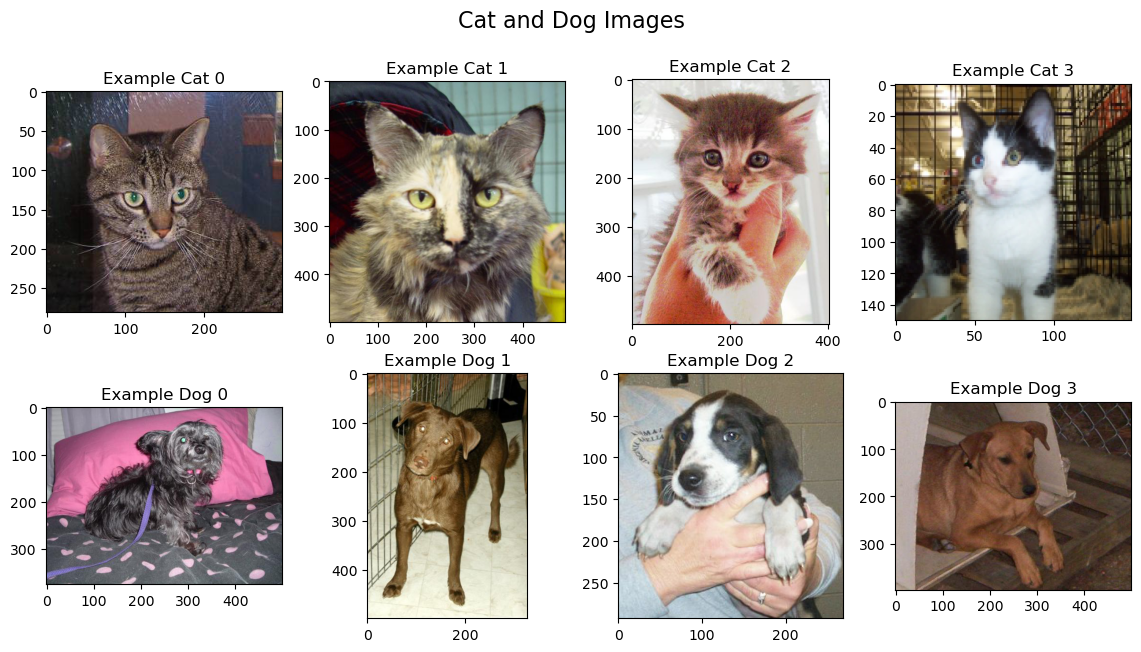

In [3]:
# Get the filenames for cats and dogs images
cats_filenames = [os.path.join(data_dir_cats, filename) for filename in os.listdir(data_dir_cats)]
dogs_filenames = [os.path.join(data_dir_dogs, filename) for filename in os.listdir(data_dir_dogs)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cat and Dog Images', fontsize=16)

# Plot the first 4 images of each class
for i, cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cat {i}')

for i, dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dog {i}')

plt.show()

In [4]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=DATA_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=0.15,
        subset='both',
        seed=42
    )

    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [ ]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

In [ ]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

In [ ]:
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """

    ### START CODE HERE ###
    FILL_MODE = 'nearest'
    
    augmentation_model = tf.keras.Sequential([ 
		# Specify the input shape.
        tf.keras.Input(shape=(120,120,3)),
        # Add the augmentation layers
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ]) 
    
    ### END CODE HERE ###

    return augmentation_model

In [ ]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

## Model

In [ ]:
def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

	# Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

	# Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2), 
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ]) 

  
    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'] 
	)  

    ### END CODE HERE ###

    return model

In [ ]:
# Create the compiled but untrained model
model = create_model()

## EarlyStoppingCallback

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.8 and validation accuracy is greater or equal to 0.8
        if logs.get('accuracy') >= 0.8 and logs.get('val_accuracy') >= 0.8:
            self.model.stop_training = True 

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

### END CODE HERE ###

## Training

In [ ]:
# This may take up to 10-15 min so feel free to take a break! :P
history = model.fit(
	training_dataset,
	epochs=35,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

## Validation

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()